In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

In [2]:
print("--- Loading Historical Dataset with RH Features ---")
# Load the dataset you just created
try:
    df = pd.read_csv('../data/df_historical.csv', index_col='Date', parse_dates=True)
    print("Successfully loaded df_historical.csv")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print("ERROR: df_historical.csv not found. Please run the previous data creation script.")
    exit()

--- Loading Historical Dataset with RH Features ---
Successfully loaded df_historical.csv
Shape: (9422, 15)


In [3]:
# --- Step 1: Create Multi-Horizon Target Variables ---
print("\n--- Creating Target Variables ---")
# Create target variables for t+1 to t+3
for horizon in range(1, 4):
    df[f'Target_Max_Temp_C_t+{horizon}'] = df['Max_Temp_C'].shift(-horizon)
    df[f'Target_Min_Temp_C_t+{horizon}'] = df['Min_Temp_C'].shift(-horizon)

# Drop rows where targets are NaN (the last 3 rows of the dataframe)
df.dropna(subset=[f'Target_Max_Temp_C_t+3'], inplace=True)
print("Target variables created.")


--- Creating Target Variables ---
Target variables created.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9419 entries, 1999-01-01 to 2024-10-14
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Precipitation_mm              9419 non-null   float64
 1   Min_Temp_C                    9419 non-null   float64
 2   Max_Temp_C                    9419 non-null   float64
 3   Precipitation_7d_rolling_sum  9419 non-null   float64
 4   Year                          9419 non-null   int64  
 5   Month                         9419 non-null   int64  
 6   Day_of_Year                   9419 non-null   int64  
 7   Day_of_Week                   9419 non-null   int64  
 8   Month_sin                     9419 non-null   float64
 9   Month_cos                     9419 non-null   float64
 10  Day_of_Year_sin               9419 non-null   float64
 11  Day_of_Year_cos               9419 non-null   float64
 12  RH_mean                       9419 non-null 

In [5]:
# --- Step 2: Define Features (X) and Targets (y) ---
print("\n--- Defining Features and Targets ---")
target_cols = [col for col in df.columns if 'Target_' in str(col)]
# Features are all columns except the original temp values and the targets
feature_cols = [col for col in df.columns if col not in ['Max_Temp_C', 'Min_Temp_C'] + target_cols]

X = df[feature_cols]
y = df[target_cols]
print(f"Number of features: {len(X.columns)}")
print(f"Number of targets: {len(y.columns)}")



--- Defining Features and Targets ---
Number of features: 13
Number of targets: 6


In [6]:
# --- Step 3: Chronological Train-Test Split ---
print("\n--- Splitting Data into Training and Test Sets ---")
split_date = '2020-01-01'
X_train = X[X.index < split_date]
y_train = y[y.index < split_date]
X_test = X[X.index >= split_date]
y_test = y[y.index >= split_date]
print(f"Training data from {X_train.index.min()} to {X_train.index.max()}")
print(f"Test data from {X_test.index.min()} to {X_test.index.max()}")


--- Splitting Data into Training and Test Sets ---
Training data from 1999-01-01 00:00:00 to 2019-12-31 00:00:00
Test data from 2020-01-01 00:00:00 to 2024-10-14 00:00:00


In [7]:
# --- Step 4: Train and Evaluate New Baseline (Linear Regression) ---
print("\n--- Training New Baseline Model (Linear Regression) ---")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_pred_lr_df = pd.DataFrame(y_pred_lr, index=y_test.index, columns=y_test.columns)

print("\n--- New Baseline Model Performance on Test Set (3-Day Horizon) ---")
for i in range(3):
    horizon = i + 1
    mae_max = mean_absolute_error(y_test[f'Target_Max_Temp_C_t+{horizon}'], y_pred_lr_df[f'Target_Max_Temp_C_t+{horizon}'])
    mae_min = mean_absolute_error(y_test[f'Target_Min_Temp_C_t+{horizon}'], y_pred_lr_df[f'Target_Min_Temp_C_t+{horizon}'])
    rmse_max = root_mean_squared_error(y_test[f'Target_Max_Temp_C_t+{horizon}'], y_pred_lr_df[f'Target_Max_Temp_C_t+{horizon}'])
    rmse_min = root_mean_squared_error(y_test[f'Target_Min_Temp_C_t+{horizon}'], y_pred_lr_df[f'Target_Min_Temp_C_t+{horizon}'])
    print(f"Horizon t+{horizon}: Max Temp MAE = {mae_max:.2f}°C | Min Temp MAE = {mae_min:.2f}°C")
    print(f"Horizon t+{horizon}: Max Temp RMSE = {rmse_max:.2f}°C | Min Temp RMSE = {rmse_min:.2f}°C")


--- Training New Baseline Model (Linear Regression) ---

--- New Baseline Model Performance on Test Set (3-Day Horizon) ---
Horizon t+1: Max Temp MAE = 2.03°C | Min Temp MAE = 1.67°C
Horizon t+1: Max Temp RMSE = 2.59°C | Min Temp RMSE = 2.21°C
Horizon t+2: Max Temp MAE = 2.17°C | Min Temp MAE = 1.61°C
Horizon t+2: Max Temp RMSE = 2.76°C | Min Temp RMSE = 2.14°C
Horizon t+3: Max Temp MAE = 2.23°C | Min Temp MAE = 1.58°C
Horizon t+3: Max Temp RMSE = 2.82°C | Min Temp RMSE = 2.09°C


In [8]:
# --- Step 5: Tune and Train New XGBoost Model ---
# The tuning process remains the same, but it's now optimizing for a simpler problem.
print("\n--- Tuning New XGBoost Model with RandomizedSearchCV ---")
# (This section remains unchanged, but is included for completeness)
param_dist = {
    'n_estimators': [150, 300, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6], 'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9], 'gamma': [0, 0.1], 'min_child_weight': [1, 3, 5]
}
def custom_mae_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return -mean_absolute_error(y_true.iloc[:, 0], y_pred[:, 0])

tscv = TimeSeriesSplit(n_splits=5)
xgb_estimator = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(estimator=xgb_estimator, param_distributions=param_dist, n_iter=50, scoring=custom_mae_scorer, cv=tscv, verbose=1, random_state=42)
random_search.fit(X_train, y_train)
print(f"\nBest parameters found: {random_search.best_params_}")


--- Tuning New XGBoost Model with RandomizedSearchCV ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found: {'subsample': 0.9, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}


In [9]:
best_xgb_model = random_search.best_estimator_

In [10]:
# --- Step 6: Final Evaluation of Tuned XGBoost Model ---
print("\n--- Fitting Final Tuned XGBoost Model with Early Stopping ---")
# (This section remains unchanged)
best_xgb_model.set_params(early_stopping_rounds=50, eval_metric='mae')
X_train_fit, X_val_fit, y_train_fit, y_val_fit = X_train.iloc[:-len(X_test)], X_train.iloc[-len(X_test):], y_train.iloc[:-len(y_test)], y_train.iloc[-len(y_test):]
best_xgb_model.fit(X_train_fit, y_train_fit, eval_set=[(X_val_fit, y_val_fit)], verbose=False)

y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_xgb_df = pd.DataFrame(y_pred_xgb, index=y_test.index, columns=y_test.columns)

print("\n--- Final Tuned XGBoost Model (Model_Historical) Performance (3-Day Horizon) ---")
# MODIFICATION: Changed range to 3
for i in range(3):
    horizon = i + 1
    mae_max = mean_absolute_error(y_test[f'Target_Max_Temp_C_t+{horizon}'], y_pred_xgb_df[f'Target_Max_Temp_C_t+{horizon}'])
    mae_min = mean_absolute_error(y_test[f'Target_Min_Temp_C_t+{horizon}'], y_pred_xgb_df[f'Target_Min_Temp_C_t+{horizon}'])
    rmse_max = root_mean_squared_error(y_test[f'Target_Max_Temp_C_t+{horizon}'], y_pred_xgb_df[f'Target_Max_Temp_C_t+{horizon}'])
    rmse_min = root_mean_squared_error(y_test[f'Target_Min_Temp_C_t+{horizon}'], y_pred_xgb_df[f'Target_Min_Temp_C_t+{horizon}'])
    print(f"Horizon t+{horizon}: Max Temp MAE = {mae_max:.2f}°C | Min Temp MAE = {mae_min:.2f}°C")
    print(f"Horizon t+{horizon}: Max Temp RMSE = {rmse_max:.2f}°C | Min Temp RMSE = {rmse_min:.2f}°C")





--- Fitting Final Tuned XGBoost Model with Early Stopping ---

--- Final Tuned XGBoost Model (Model_Historical) Performance (3-Day Horizon) ---
Horizon t+1: Max Temp MAE = 1.64°C | Min Temp MAE = 1.39°C
Horizon t+1: Max Temp RMSE = 2.25°C | Min Temp RMSE = 1.86°C
Horizon t+2: Max Temp MAE = 1.72°C | Min Temp MAE = 1.35°C
Horizon t+2: Max Temp RMSE = 2.36°C | Min Temp RMSE = 1.80°C
Horizon t+3: Max Temp MAE = 1.75°C | Min Temp MAE = 1.30°C
Horizon t+3: Max Temp RMSE = 2.40°C | Min Temp RMSE = 1.74°C


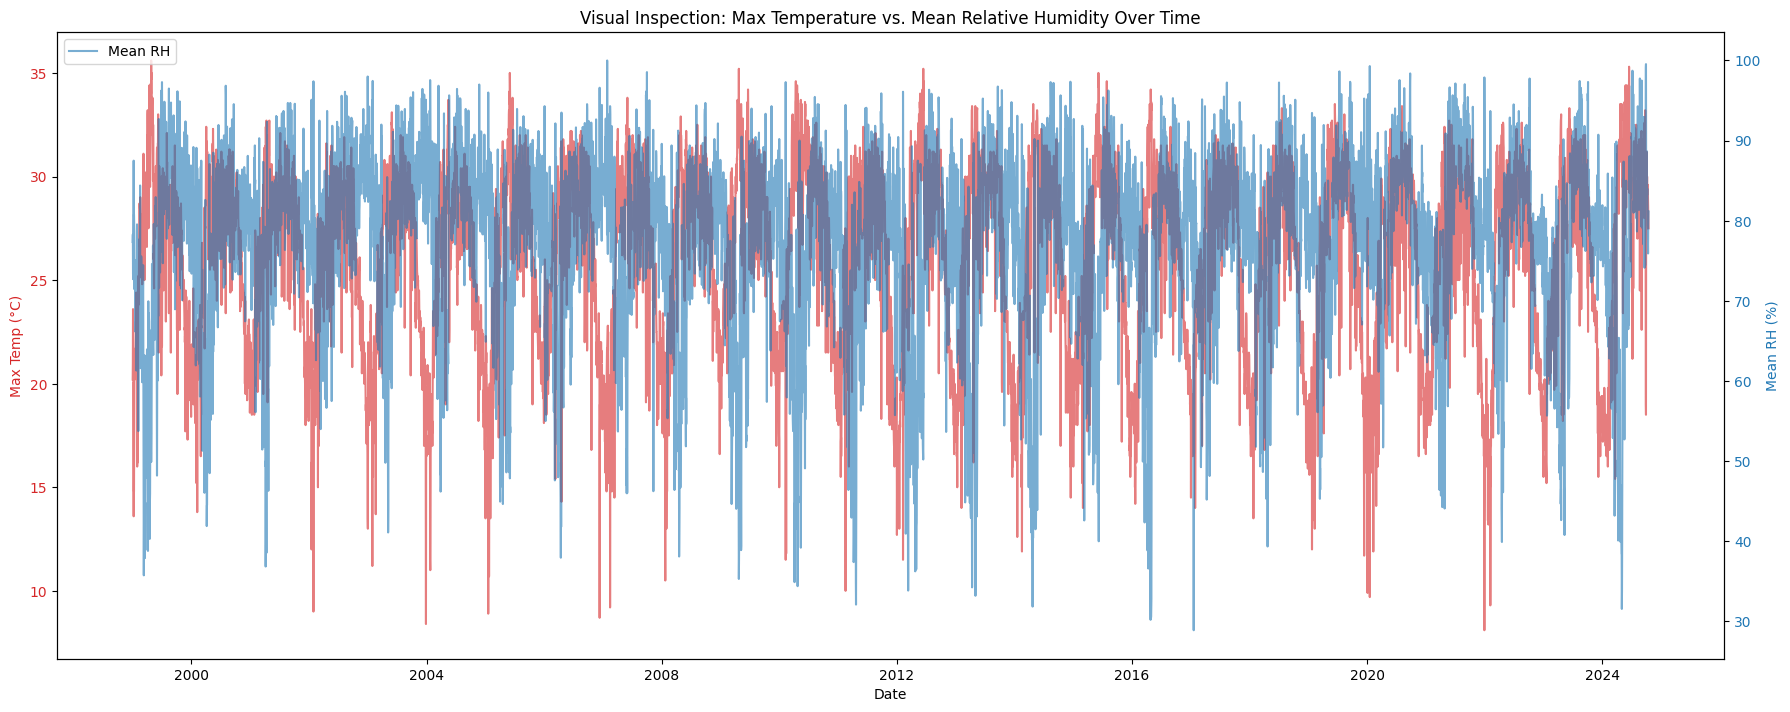


--- Summary Statistics for RH Features ---
           RH_mean       RH_min       RH_max
count  9419.000000  9419.000000  9419.000000
mean     77.057347    65.266073    87.918013
std      11.048242    15.383755    10.664694
min      28.900000    10.200000    30.300000
25%      72.000000    55.335000    82.600000
50%      79.350000    67.700000    90.800000
75%      84.544375    76.700000    96.400000
max     100.000000   100.000000   100.000000


In [11]:
import matplotlib.pyplot as plt

# 1. Create a plot to visually inspect RH and Max Temperature together
fig, ax1 = plt.subplots(figsize=(18, 7))

# Plot Max Temperature on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Max Temp (°C)', color=color)
ax1.plot(df.index, df['Max_Temp_C'], color=color, alpha=0.6, label='Max Temp')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Relative Humidity
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Mean RH (%)', color=color)
ax2.plot(df.index, df['RH_mean'], color=color, alpha=0.6, label='Mean RH')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Visual Inspection: Max Temperature vs. Mean Relative Humidity Over Time')
plt.savefig('../images/historic_data_visual_inspection.png', dpi=300, bbox_inches='tight')
plt.legend(loc='upper left')
plt.show()

# 2. Get summary statistics for the new RH columns
print("\n--- Summary Statistics for RH Features ---")
print(df[['RH_mean', 'RH_min', 'RH_max']].describe())